Copied from fabric_gan_dropout.ipynb
packaging with pyfunc

In [1]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd  /content/drive/My\ Drive/AISC_GAN_ws_2020/african_fabric/packaging/
%pwd
%ls

/content/drive/My Drive/AISC_GAN_ws_2020/african_fabric/packaging
data/  fabric_gan_package.ipynb  model.py  __pycache__/


In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

optim
print('\nDone with setting seed')

Random Seed:  999

Done with setting seed


In [0]:
import os
from pathlib import Path
from model import nc
from model import nz
from model import ngf
from model import ndf
from model import ngpu

dataroot = Path('../data/')

#%ls $dataroot
os.listdir(dataroot)

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
#nc = 3

# Size of z latent vector (i.e. size of generator input)
#nz = 100

# Size of feature maps in generator
#ngf = 64

# Size of feature maps in discriminator
#ndf = 64

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lrd = 2e-4
lrg = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
#ngpu = 1

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

print('VIK : cuda = ',torch.cuda.is_available())

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print('\ndevice = ',device)
print('\nlrd = ',lrd)
print('\nlrg = ',lrg)
print('\nnum_epochs = ',num_epochs)

# Plot some training images
real_batch = next(iter(dataloader))

VIK : cuda =  True

device =  cuda:0

lrd =  0.0002

lrg =  0.0002

num_epochs =  2


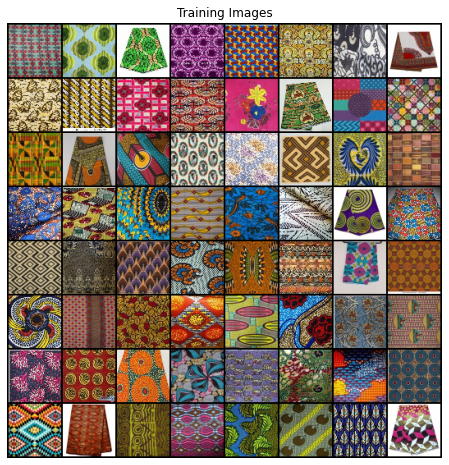

In [6]:
#print('\ntype = ',type(real_batch))
#print('\nshape = ',len(real_batch))

#print('\nshape = ',real_batch[0].shape)
#print('\nshape = ',real_batch[1].shape)
#print(type(real_batch[1]))
#print('\nreal_batch = ',real_batch[1][0:64])

#real_batch = next(iter(dataloader))
#real_batch = next(iter(dataloader))


plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, init_zero_weights=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
# def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, bias=False):
#     """Creates a transposed-convolutional layer, with optional batch normalization.
#     """
#     layers = []
#     layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias))
#     if batch_norm:
#         layers.append(nn.BatchNorm2d(out_channels))
#     return nn.Sequential(*layers)

In [0]:
# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         # Fill this in
#         self.convT1 = deconv(nz, ngf*8, 4, 1, 0)
#         self.convT2 = deconv(ngf*8, ngf*4, 4, 2, 1)
#         self.convT3 = deconv(ngf*4, ngf*2, 4, 2, 1)
#         self.convT4 = deconv(ngf*2, ngf, 4, 2, 1)
#         self.output = deconv(ngf, nc, 4, 2, 1, batch_norm=False)

#     def forward(self, input):
#         out = F.relu(self.convT1(input), inplace=True)
#         out = F.relu(self.convT2(out), inplace=True)
#         out = F.relu(self.convT3(out), inplace=True)
#         out = F.relu(self.convT4(out), inplace=True)
#         return F.tanh(self.output(out))
    

In [9]:
from model import Generator

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (convT1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


Discriminator Code



In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        # Fill this in
        self.conv1 = conv(nc, ndf, 4, 2, 1)
        self.conv2 = conv(ndf, ndf * 2, 4, 2, 1)
        self.conv3 = conv(ndf * 2, ndf * 4, 4, 2, 1)
        self.conv4 = conv(ndf * 4, ndf * 8, 4, 2, 1)
        self.output = conv(ndf * 8, 1, 4, 1, 0, batch_norm=False)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input):
        out = F.leaky_relu(self.conv1(input), inplace=True)
        out = F.leaky_relu(self.conv2(out), inplace=True)
        out = F.leaky_relu(self.conv3(out), inplace=True)
        out = F.leaky_relu(self.conv4(out), inplace=True)
        out = self.dropout(out)
        return F.sigmoid(self.output(out))
        # what does the return line look like?

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0
#real_label = 0.9
#fake_label = 0.1

#for ii in np.arange(5):
# print('\nuniform = ',np.random.uniform(0.0,0.1))
#for ii in np.arange(5):
# print('\nuniform = ',np.random.uniform(0.9,1.0)) 

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrd, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrg, betas=(beta1, 0.999))

In [0]:
checkpoint_dir = '/content/drive/My Drive/AISC_GAN_ws_2020/african_fabric/packaging/data/' 

def create_dir(directory):
    """Creates a directory if it does not already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

create_dir(checkpoint_dir)
def checkpoint(iteration, G, D):
    """
    Saves the parameters of the generator G and discriminator D.
    """
    G_path = os.path.join(checkpoint_dir, 'G.pkl')
    D_path = os.path.join(checkpoint_dir, 'D.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def load_checkpoint(model, checkpoint_name):
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, checkpoint_name)))

In [0]:
# Training Loop 
#import torch.nn.functional as F


# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs*25):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #np.random.uniform(0.0,0.1)
        #label = torch.full((b_size,), real_label, device=device)
        label = torch.full((b_size,),np.random.uniform(0.9,1.0), device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Fill this in
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        #label.fill_(fake_label)
        label.fill_(np.random.uniform(0.0,0.1))
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        # Fill this in
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

In [15]:
print('\niters = ',iters)
print('\nnum_epochs = ',num_epochs)
print('\nepochs = ',num_epochs*25)
print('\nlen(dataloader) = ',len(dataloader))
print('\nlen(G_losses) = ', len(G_losses))
print('\nlen(img_list) = ', len(img_list))
print('\ntype(img_list) = ', type(img_list[0]))
print('\nimg_list.shape = ', img_list[0].shape)


iters =  850

num_epochs =  2

epochs =  50

len(dataloader) =  17

len(G_losses) =  850

len(img_list) =  3

type(img_list) =  <class 'torch.Tensor'>

img_list.shape =  torch.Size([3, 530, 530])


In [0]:
#@title Training Loop Solution {display-mode: "form"}


# Training Loop
"""
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs*25):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
"""

In [0]:
# import matplotlib.pyplot as plt
# from pathlib import Path
# import pickle

# savedir = Path('./data/result_dropout_noisylabels_25/')

# print(savedir)

# create_dir(savedir)

# listparams = [nc,nz,ngf,ndf,lrd,lrg,beta1,num_epochs]
# with open(savedir/'listparams.pkl','wb') as f:
#   pickle.dump(listparams,f) 

# with open(savedir/'G_losses.pkl','wb') as f:
#   pickle.dump(G_losses,f) 
# with open(savedir/'D_losses.pkl','wb') as f:
#   pickle.dump(D_losses,f) 
# with open(savedir/'img_list.pkl','wb') as f:
#   pickle.dump(img_list,f) 

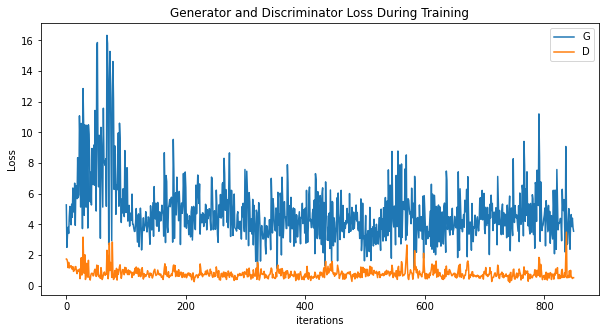

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
#plt.ylim([0,1])
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [17]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




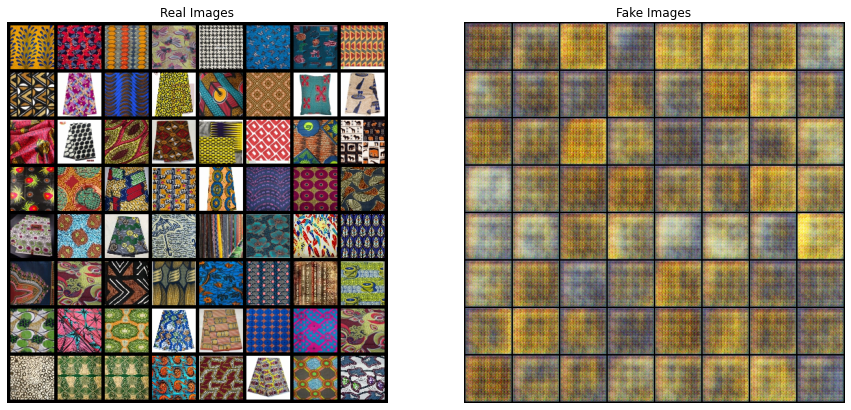

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

PACKAGING

In [0]:
!pip install MLflow

In [0]:
import mlflow
import mlflow.pyfunc

In [0]:
#print(netG.state_dict())
# Serialize the models state_dict
#state_dict_path = f'/content/state_dict.pt'
state_dict_path = f'/content/drive/My Drive/AISC_GAN_ws_2020/african_fabric/packaging/model/state_dict.pt'

torch.save(netG.state_dict(), state_dict_path)

In [23]:
!ls /content/drive/My\ Drive/AISC_GAN_ws_2020/african_fabric/packaging/model/

state_dict.pt


In [0]:
# Here we will create an artifacts object
# It will contain all of the data artifacts that we want to package with the model
artifacts = {
    "state_dict": state_dict_path
}


class ModelWrapper(mlflow.pyfunc.PythonModel):

    # Load in the model and all required artifacts
    # The context object is provided by the MLflow framework
    # It will contain all of the artifacts specified above
    def load_context(self, context):
      import torch
      import pickle
      from model import Generator
      from model import nz
      from model import ngpu

      self.device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

    # Initialize the model and load in the state dict
      self.model = Generator(ngpu).to(self.device)
      self.model.load_state_dict(torch.load(context.artifacts["state_dict"]))

    def predict(self, context, model_input):

      #model_input can be potentially be used as a  seed to make sure that nz random bumbers arenot repeated.
      netG = self.model
      fixed_noise = torch.randn(64, nz, 1, 1, device=self.device)
      fake = netG(fixed_noise).detach().cpu()
      return fake

In [25]:
# Inspect the default conda environment for MLflow
mlflow.pyfunc.get_default_conda_env()

{'channels': ['defaults'],
 'dependencies': ['python=3.6.9',
  'pip',
  {'pip': ['mlflow', 'cloudpickle==1.3.0']}],
 'name': 'mlflow-env'}

In [0]:
# Let's create our own conda environment
conda_env = {
    'channels': ['defaults'],
    'dependencies': [
      f'python=3.6.9',
      {
          'pip':[
            f'mlflow=={mlflow.__version__}',
            f'torch=={torch.__version__}',
            'cloudpickle==1.2.2'
          ]
      }
    ],
    'name': 'mlflow-env-fabric'
}

In [51]:
print(artifacts)
!ls /content/drive/My\ Drive/AISC_GAN_ws_2020/african_fabric/packaging/model/

{'state_dict': '/content/drive/My Drive/AISC_GAN_ws_2020/african_fabric/packaging/model/state_dict.pt'}
state_dict.pt


In [52]:
# Location in our gdrive where we want the model to be saved
mlflow_pyfunc_model_path = f"/content/drive/My Drive/AISC_GAN_ws_2020/african_fabric/packaging/model/fabric_model"

# Package the model!
mlflow.pyfunc.save_model(path=mlflow_pyfunc_model_path,
                         python_model=ModelWrapper(),
                         artifacts=artifacts,
                         conda_env=conda_env,
                         code_path=['/content/drive/My Drive/AISC_GAN_ws_2020/african_fabric/packaging/model.py', '/content/drive/My Drive/AISC_GAN_ws_2020/african_fabric/packaging/meta_data.txt'])

!ls /content/drive/My\ Drive/AISC_GAN_ws_2020/african_fabric/packaging/model/
!ls /content/drive/My\ Drive/AISC_GAN_ws_2020/african_fabric/packaging/model/fabric_model/
!ls /content/drive/My\ Drive/AISC_GAN_ws_2020/african_fabric/packaging/model/fabric_model/code/

fabric_model  state_dict.pt
artifacts  code  conda.yaml  MLmodel  python_model.pkl
meta_data.txt  model.py


LOAD IN THE SERIALISED MODEL

In [53]:
# Load the model in `python_function` format
loaded_model = mlflow.pyfunc.load_model(mlflow_pyfunc_model_path)

dummy=0
outimage = loaded_model.predict(dummy)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


<class 'torch.Tensor'>
torch.Size([64, 3, 64, 64])


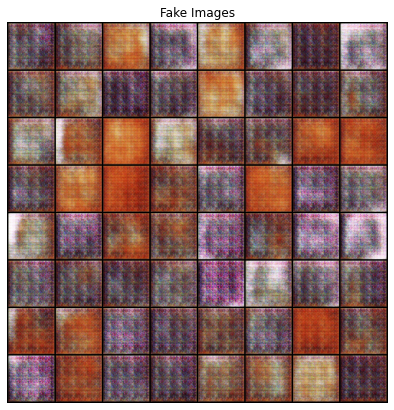

In [65]:
print(type(outimage))
print(outimage.shape)

#img = outimage.numpy()
#print(type(img))
#print(img.shape)

img_list = []
img_list.append(vutils.make_grid(outimage, padding=2, normalize=True))

# Plot the real images
plt.figure(figsize=(15,15))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
#plt.imshow(np.transpose(outimage[-1],(1,2,0)))
#plt.imshow(np.transpose(img[:,:,:,5],(0,2,1)))
plt.show()